In [51]:
from __future__ import print_function, division
import os
import argparse
import torch.nn as nn
from skimage import io
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from utils import *
from utils.KittiColormap import *
from pyntcloud import PyntCloud
import pandas as pd
from cv_bridge import CvBridge
import cv2
import matplotlib.pyplot as plt
from datasets.data_io import get_transform

%matplotlib inline

In [89]:
index = 350
left_img = np.load(f"/home/chris/pl_ws/src/stereo_pl_nav/datasets/ISEC/left/{index}.npy")
right_img = np.load(f"/home/chris/pl_ws/src/stereo_pl_nav/datasets/ISEC/right/{index}.npy")
voxel = np.load(f"/home/chris/pl_ws/src/stereo_pl_nav/datasets/ISEC/voxel/{index}.npy")

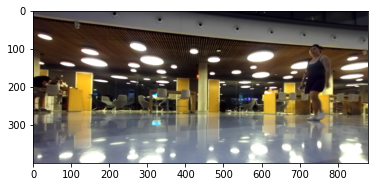

In [90]:
plt.imshow(left_img)

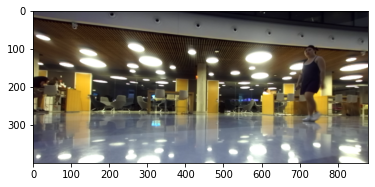

In [91]:
plt.imshow(right_img)

In [92]:
left_img.shape

(400, 880, 3)

In [93]:
depth_rgb = np.transpose(np.asarray(left_img)[:, :, :3], (2, 0, 1))
print(depth_rgb.shape)

processed = get_transform()
left_img = processed(left_img)
right_img = processed(right_img)

(3, 400, 880)


In [94]:
from models.mobilestereonet.models.MSNet2D import MSNet2D
model = MSNet2D(192)
model = nn.DataParallel(model)
model.cuda()
ckpt_path = "/home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt"
print("Loading model {}".format(ckpt_path))
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict['model'])

Loading model /home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt


<All keys matched successfully>

In [95]:
c_u = 450.5506248474121
c_v = 256.7339172363281
f_u = 366.62
f_v = 366.62
b_x = 0.12
b_y = 0.0
baseline = 0.12

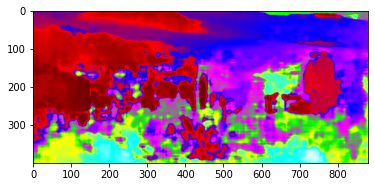

In [96]:
import matplotlib.pyplot as plt

model.eval()

sample_left = torch.Tensor(left_img)
sample_right = torch.Tensor(right_img)

sample_left = torch.unsqueeze(sample_left, dim=0)
sample_right = torch.unsqueeze(sample_right, dim=0)

with torch.no_grad():
    disp_est_tn = model(sample_left.cuda(), sample_right.cuda())[0]
    disp_est_np = tensor2numpy(disp_est_tn)
    disp_est = np.array(disp_est_np[0], dtype=np.float32)
    plt.imshow(kitti_colormap(disp_est))
    plt.show()
    disp_est[disp_est < 0] = 0

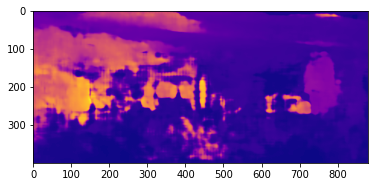

In [97]:
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()

In [98]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    n = uv_depth.shape[0]
    x = ((uv_depth[:, 0] - c_u) * uv_depth[:, 2]) / f_u + b_x
    y = ((uv_depth[:, 1] - c_v) * uv_depth[:, 2]) / f_v + b_y
    pts_3d_rect = np.zeros((n, 3))
    pts_3d_rect[:, 0] = x
    pts_3d_rect[:, 1] = y
    pts_3d_rect[:, 2] = uv_depth[:, 2]
    return pts_3d_rect

def project_image_to_velo(uv_depth):
    pts_3d_rect = project_image_to_rect(uv_depth)
    return pts_3d_rect

mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)

points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

# parse Voxel Grid

In [99]:
def get_visualize(voxel, color=[1.0, 0.0, 0.0]):

    offsets = np.array([32, 63, 0])
    voxel_size = 0.1
    xyz_pred = np.asarray(np.where(voxel == 1)) # get back indexes of populated voxels
    cloud_pred = np.asarray([(pt-offsets)*voxel_size for pt in xyz_pred.T])
    
    pred_pcd = o3d.geometry.PointCloud()
    pred_pcd.points = o3d.utility.Vector3dVector(cloud_pred)
    pred_pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(cloud_pred), 3)))
    
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pred_pcd,
                                                              voxel_size=0.1)    
    return voxel_grid

In [100]:
import open3d as o3d

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

o3d.visualization.draw_geometries([rgbd_pcd, get_visualize(voxel)])